# Deep learning and Dogs vs. Cats - Part&nbsp;1&frac12;
##  Data set https://www.kaggle.com/c/dogs-vs-cats
(the data set should be installed in two directories just above the one where this notebook is located: train and test1)
### Part 1 can be found here: http://ricardodeazambuja.com/deep_learning/2017/01/29/easy-peasy_deep_learning/

### http://ricardodeazambuja.com/deep_learning/2017/02/10/easy-peasy_deep_learning_one_and_a_half/

In [2]:
# The package 'os' will be necessary to find the current
# working directory os.getcwd() and also to list all
# files in a directory os.listdir().
import os

# https://docs.python.org/2/library/multiprocessing.html
from multiprocessing import Pool

# Only used for the final test
import urllib, cStringIO

# Yep, I don't like to import numpy as np :P
import numpy

# As I've explained somewhere, Scipy will help us
# reading (using Pillow) and resizing images.
import scipy.misc

# Pyplot is what we use for plotting
import matplotlib.pyplot as plt


# And here is the Keras stuff:

# We don't really need this since it would 
# be easy do code something like this ourselves
from keras.utils import np_utils

# https://keras.io/getting-started/sequential-model-guide/
from keras.models import Sequential
from keras.models import Model

from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout

# https://keras.io/optimizers/
from keras.optimizers import SGD
from keras.optimizers import Adagrad 

# While the method for saving a model is
# part of the model object, to load we need
# to import something else
from keras.models import load_model

## 1) Load the data sets

In [3]:
# Returns the current working directory
# (where the Python interpreter was called)
path = os.getcwd()

# The path separator used by the OS:
sep = os.path.sep

# This is the directory where the training images are located
dirname = "train"

# Generates a list of all images (actualy the filenames) from the training set,
# but it will also include the full path
imagePaths = [path+sep+dirname+sep+filename 
                  for filename in os.listdir(path+sep+dirname)]

In [4]:
# To speed up things, I will use parallel computing!
# Pool lets me use its map method and select the number of parallel processes.

def import_training_set(args):
    '''
    Reads the image from imagePath, resizes 
    and returns it together with its label and 
    original index.

    '''
    index,imagePath,new_image_size = args

    # Reads the image
    image = scipy.misc.imread(imagePath)

    # Split will literally split a string at that character
    # returning a list of strings.
    # First we split according to the os.path.sep and keep 
    # only the last item from the list gererated ([-1]).
    # This will give us the filename. 
    filename = imagePath.split(os.path.sep)[-1]
    
    # Then we split it again using "."  
    # and extract the first item ([0]):
    label = filename.split(".")[0]
    
    # and the second item ([1]):
    original_index = filename.split(".")[1]

    # Resizes the image (downsampling) to new_image_size and
    # converts it to a 1D list (flatten).
    input_vector = scipy.misc.imresize(image,new_image_size).flatten()

    return (index,(original_index,label,input_vector))

In [5]:
%%time
# The size of the resized image.
# After we apply the flatten method, it will become a list of 32x32x3 items (1024x3).
# (Where is the 'x3' coming from? Our images are composed of three colors!)
new_image_size = 32,32

number_of_parallel_processes = 7

# When the map is finished, we will receive a list with tuples:
# (index,(original_index,label,input_vector)) => (index,(original_index,'category',1D resized image))
#
# There's no guarantee about the ordering because they are running in parallel.
ans = Pool(number_of_parallel_processes).map(import_training_set,[(i,img,new_image_size) 
                                                                  for i,img in enumerate(imagePaths)])

CPU times: user 236 ms, sys: 99.4 ms, total: 336 ms
Wall time: 40.2 s


In [6]:
# Because import_training_set returns a tuple like this:
# (index,(original_index,label,input_vector))
# and index is unique, we can convert to a dictionary
# to solve our problem with unordered items:
training_set = dict(ans)

# Gives a hint to the garbage collector...
del ans

In [7]:
# Let's verify if we loaded all images:
len(training_set)

25000

In [13]:
# And now test to see what is inside:
training_set[0],training_set[24999]

(('0', 'cat', array([211, 172,  94, ...,   3,   3,   0], dtype=uint8)),
 ('9999', 'dog', array([249, 243, 235, ..., 254, 254, 254], dtype=uint8)))

## 2) Prepare the data set for Keras

In [14]:
# Let's imagine we don't know how many different labels we have.
# (we know, they are 'cat' and 'dog'...)
# A Python set can help us to create a list of unique labels.
# (i[0]=>filename index, i[1]=>label, i[2]=>1D vector)
unique_labels = set([i[1] for i in training_set.values()])

# With a list of unique labels, we will generate a dictionary
# to convert from a label (string) to a index (integer):
labels2int = {j:i for i,j in enumerate(unique_labels)}


# Creates a list with labels (ordered according to the dictionary index)
labels = [labels2int[i[1]] for i in training_set.values()]

In [15]:
# Instead of '1' and '0', the function below will transform our labels
# into vectors [0.,1.] and [1.,0.]:
labels = np_utils.to_categorical(labels, 2)

In [16]:
# First, we will create a numpy array going from zero to len(training_set):
# (dtype=int guarantees they are integers)
random_selection = numpy.arange(len(training_set),dtype=int)

# Then we create a random state object with our seed:
# (the seed is useful to be able to reproduce our experiment later)
seed = 12345
rnd = numpy.random.RandomState(seed)

# Finally we shuffle the random_selection array:
rnd.shuffle(random_selection)

In [17]:
test_size=0.25 # we will use 25% for testing purposes

# Breaking the code below to make it easier to understand:
# => training_set[i][-1]
# Returns the 1D vector from item 'i'.
# => training_set[i][-1]/255.0
# Normalizes the input values from 0. to 1.
# => random_selection[:int(len(training_set)*(1-test_size))]
# Gives us the first (1-test_size)*100% of the shuffled items
trainData = [training_set[i][-1]/255.0 for i in random_selection[:int(len(training_set)*(1-test_size))]]
trainData = numpy.array(trainData)

trainLabels = [labels[i] for i in random_selection[:int(len(training_set)*(1-test_size))]]
trainLabels = numpy.array(trainLabels)

testData = [training_set[i][-1]/255.0 for i in random_selection[:int(len(training_set)*(test_size))]]
testData = numpy.array(testData)

testLabels = [labels[i] for i in random_selection[:int(len(training_set)*(test_size))]]
testLabels = numpy.array(testLabels)

### Before we move forward, let's create a super simple 2x2 RGB image and try to understand what are we doing with our images before injecting them into the network:

In [18]:
# Using sympy to print nice LaTeX based matrices:
# http://docs.sympy.org/dev/tutorial/printing.html
from sympy import Matrix, init_printing
# init_printing(use_latex=True)
init_printing(use_latex='png')  # Makes easier to add to a post without using MathML

In [19]:
img = numpy.zeros((2,2,3))  # RGB=>3 
img[0,0,0] = 1.  #(0,0) - R layer=>0 
img[0,1,1] = 1.  #(0,1) - G layer=>1
img[1,0,2] = 1.  #(0,0) - B layer=>1
img[1,1,:] = 0.  #(1,1) - R,G,B layers=>0. In RGB, a zero value for all colours means black.
img

array([[[ 1.,  0.,  0.],
        [ 0.,  1.,  0.]],

       [[ 0.,  0.,  1.],
        [ 0.,  0.,  0.]]])

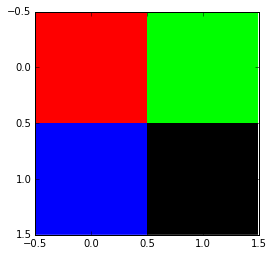

In [20]:
plt.imshow(img,interpolation='none')
plt.show()

### Now, we verify what flatten is doing to our image:

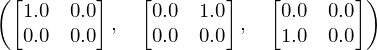

In [21]:
# First, visualize the R,G and B matrices using Sympy / LaTeX:
Matrix(img[:,:,0]) , Matrix(img[:,:,1]), Matrix(img[:,:,2])

In [22]:
print "Flattened (now 1D array):"
print img.flatten()
print
print "Flattened (now highlighting how the 2x2 matrices become a 1D array):"
print "(Flatten gets element 0 from all 3 matrices, then element 1... and at the end just glue them together)"
print img.flatten().reshape(4,3)
print
print "Original (2x2x3 array):"
print img.flatten().reshape((2,2,3))

Flattened (now 1D array):
[ 1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.]

Flattened (now highlighting how the 2x2 matrices become a 1D array):
(Flatten gets element 0 from all 3 matrices, then element 1... and at the end just glue them together)
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  0.]]

Original (2x2x3 array):
[[[ 1.  0.  0.]
  [ 0.  1.  0.]]

 [[ 0.  0.  1.]
  [ 0.  0.  0.]]]


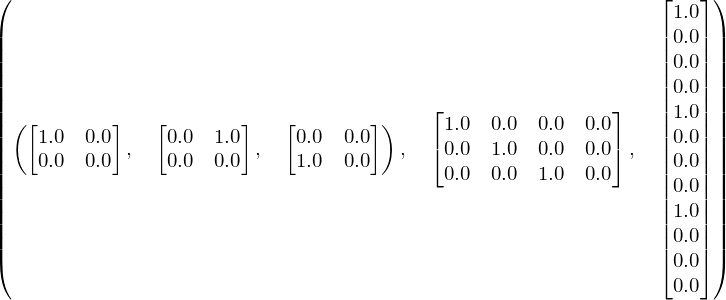

In [23]:
(Matrix(img[:,:,0]) , Matrix(img[:,:,1]), Matrix(img[:,:,2])),Matrix(img.flatten().reshape(4,3).T),Matrix(img.flatten())

### If you reshape an image, the wrong way, it can look very crazy!

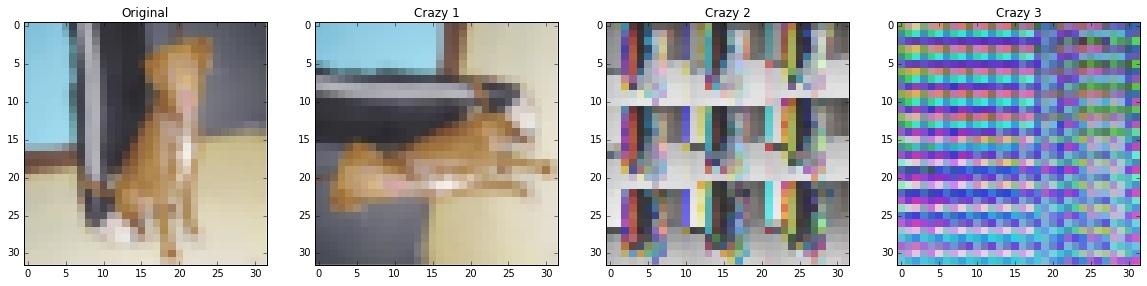

In [24]:
plt.figure(figsize=(20,10))
plt.subplot(141)
plt.imshow((testData[1].reshape(32,32,3)), interpolation='none')
plt.title("Original")
plt.subplot(142)
plt.imshow((numpy.rollaxis(testData[1].reshape(32,32,3), 1, 0)).reshape(32,32,3), interpolation='none')
plt.title("Crazy 1")
plt.subplot(143)
plt.imshow((numpy.rollaxis(testData[1].reshape(32,32,3), 2, 0)).reshape(32,32,3), interpolation='none')
plt.title("Crazy 2")
plt.subplot(144)
plt.imshow(numpy.rollaxis(testData[1].reshape(3,32,32), 0, 3), interpolation='none')
plt.title("Crazy 3")
plt.show()

In [25]:
# # I'm not using it, but it's useful, so I will let it here ;)
# old_options = numpy.get_printoptions()
# # numpy.set_printoptions(old_options)
# old_options

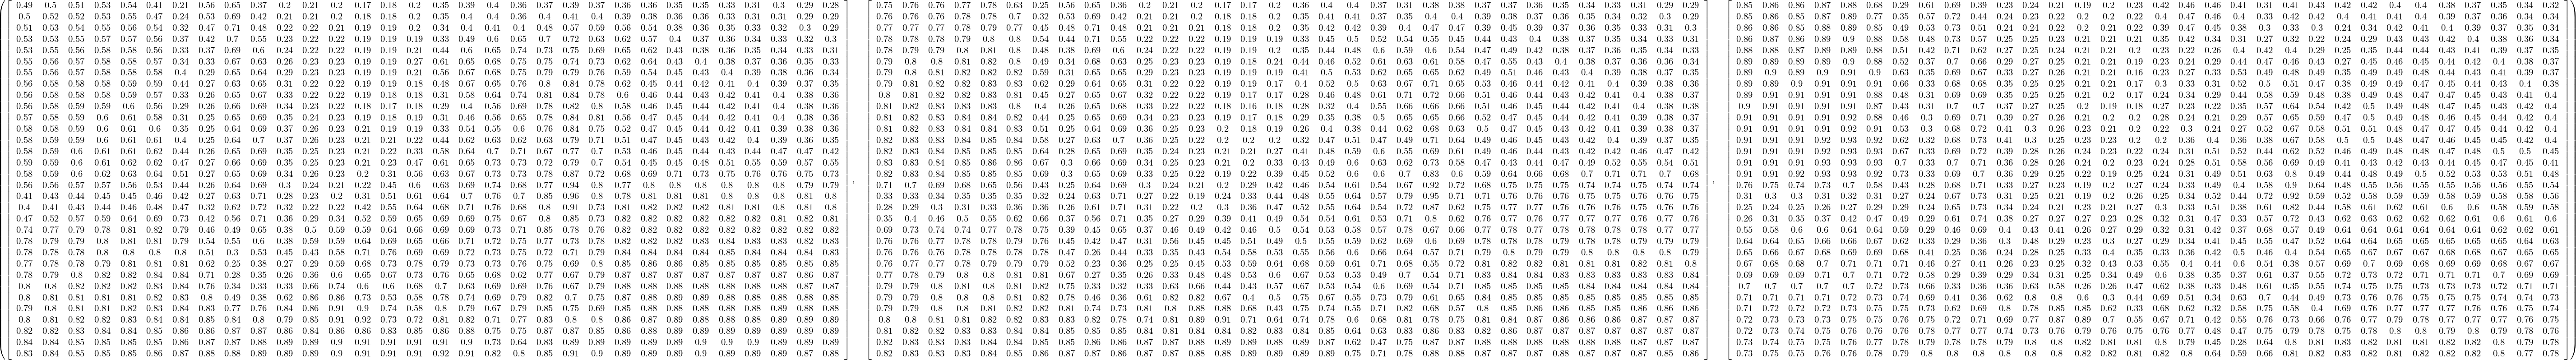

In [26]:
# The original image RGB matrices
img_round = numpy.round(testData[1].reshape(32,32,3),decimals=2)
Matrix(img_round[:,:,0]),Matrix(img_round[:,:,1]),Matrix(img_round[:,:,2])

## 3) Create a Sequential model

Now, we will give names to our layers and make life easier.

In [112]:
# https://keras.io/getting-started/sequential-model-guide/
# define the architecture of the network
model_rnd = Sequential()

# input layer has size "input_dim" (new_image_size[0]*new_image_size[1]*3). 
# The first hidden layer will have size 768, followed by 384 and 2.
# 3072=>768=>384=>2
input_len = new_image_size[0]*new_image_size[1]*3


# A Dense layer is a fully connected NN layer (feedforward)
# https://keras.io/layers/core/#dense
# init="uniform" will initialize the weights / bias randomly
model_rnd.add(Dense(input_len/4, input_dim=input_len, init="uniform", name="Input_layer"))

# https://keras.io/layers/core/#activation
# https://keras.io/activations/
model_rnd.add(Activation('relu', name="Input_layer_act"))


# Now this layer will have output dimension of 384
model_rnd.add(Dense(input_len/8, init="uniform", name="Hidden_layer"))

model_rnd.add(Activation('relu', name="Hidden_layer_act"))

# Because we want to classify between only two classes (binary), the final output is 2
model_rnd.add(Dense(2, name="Classifier_layer"))
model_rnd.add(Activation("softmax"))

### But the old model was created without names! 
We have, at least, two options:
    1. find or change the names
    2. recover the weights and load into the new network

In [128]:
my_97perc_acc = load_model('my_97perc_acc.h5')

In [129]:
score = my_97perc_acc.evaluate(testData, testLabels, batch_size=128, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

('Test score:', 0.13020923321247102)
('Test accuracy:', 0.97744000049591062)


In [130]:
# layers is a list with Keras layers (instances)
my_97perc_acc.layers

In [131]:
# Just to make life easier
first_layer = my_97perc_acc.layers[0]
first_layer_after_activation = my_97perc_acc.layers[1]
second_layer = my_97perc_acc.layers[2]
second_layer_after_activation = my_97perc_acc.layers[3]
classifier_layer = my_97perc_acc.layers[4]

### 1. Find/change the layer names

In [132]:
# Keras automatically attributed layer names
for layer in my_97perc_acc.layers:
    print layer.name

dense_1
activation_1
dense_2
activation_2
dense_3
activation_3


In [133]:
# But I think it's nicer to change the names to match the new model
first_layer.name = "Input_layer"
first_layer_after_activation.name = "Input_layer_act"
second_layer.name = "Hidden_layer"
second_layer_after_activation.name = "Hidden_layer_act"

In [134]:
# https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer

model = model_rnd

# model = my_97perc_acc

layer_name = 'Input_layer_act'
input_layer_out = Model(input=model.input, output=model.get_layer(layer_name).output)

layer_name = 'Hidden_layer_act'
hidden_layer_out = Model(input=model.input, output=model.get_layer(layer_name).output)

In [135]:
idx = 1
input_image = testData[idx]
first_output = input_layer_out.predict(input_image.reshape(1,testData[idx].shape[0]))
second_output = hidden_layer_out.predict(input_image.reshape(1,testData[idx].shape[0]))
second_output.resize(11*11*3)
final_output =  model.predict(input_image.reshape(1,input_image.shape[0]))

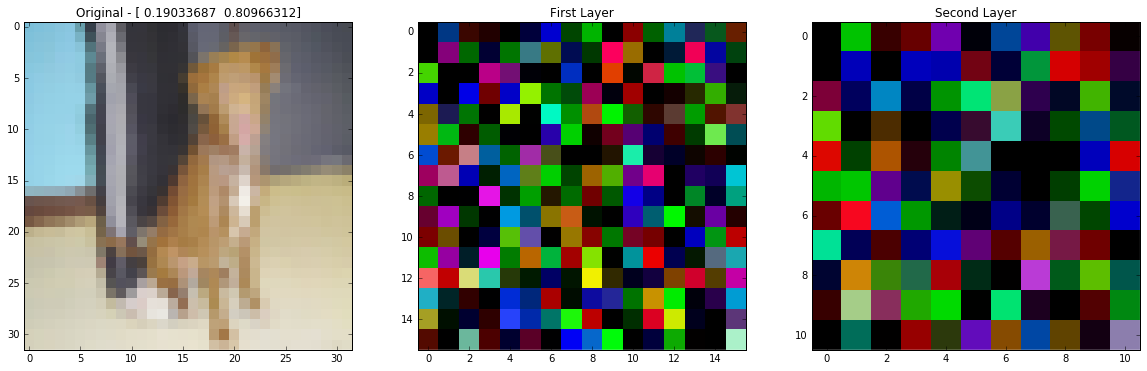

In [136]:
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow((input_image.reshape(32,32,3)), interpolation='none')
plt.title("Original - "+str(final_output[0]))
plt.subplot(132)
plt.imshow(first_output.reshape(16,16,3),interpolation='none')
plt.title("First Layer")
plt.subplot(133)
plt.imshow(second_output.reshape(11,11,3),interpolation='none')
plt.title("Second Layer")
plt.show()

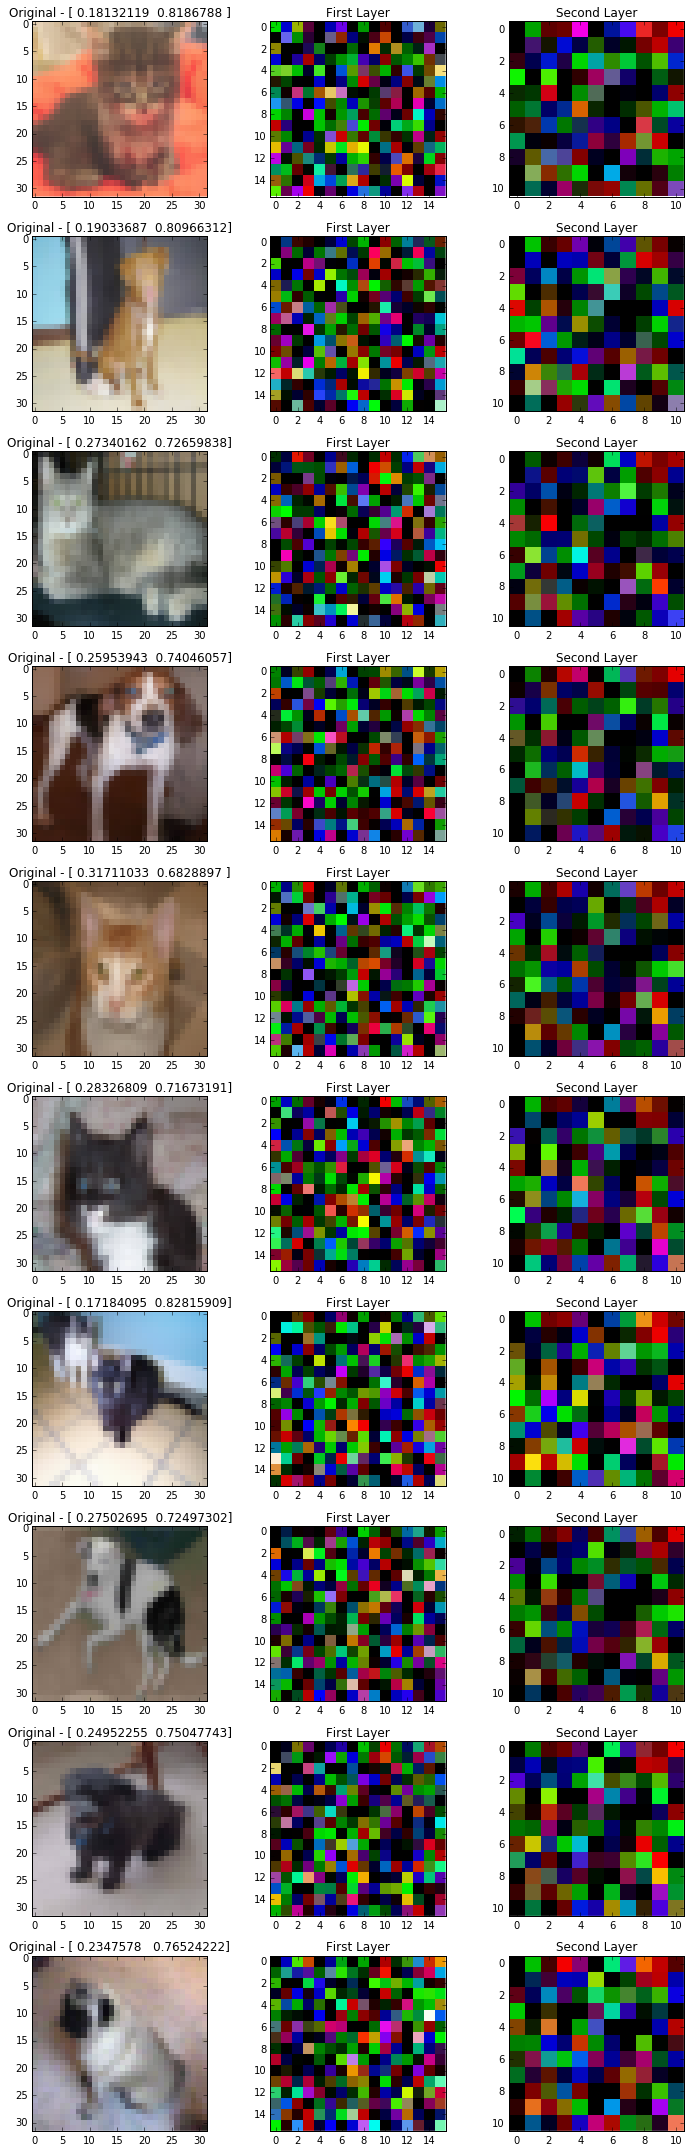

In [137]:
def layers_output(idx):
    input_image = testData[idx]
    first_output = input_layer_out.predict(input_image.reshape(1,testData[idx].shape[0]))
    second_output = hidden_layer_out.predict(input_image.reshape(1,testData[idx].shape[0]))
    second_output.resize(11*11*3)
    final_output =  model.predict(input_image.reshape(1,input_image.shape[0]))
    return input_image,first_output,second_output,final_output

total_imgs = 10

plt.figure(figsize=(10,30))
for i in range(total_imgs):
    input_image,first_output,second_output,final_output = layers_output(i)
    plt.subplot(total_imgs,3,1+i*3)
    plt.imshow((input_image.reshape(32,32,3)), interpolation='none')
    plt.title("Original - "+str(final_output[0]))
    plt.subplot(total_imgs,3,2+i*3)
    plt.imshow(first_output.reshape(16,16,3),interpolation='none')
    plt.title("First Layer")
    plt.subplot(total_imgs,3,3+i*3)
    plt.imshow(second_output.reshape(11,11,3),interpolation='none')
    plt.title("Second Layer")
plt.tight_layout()
plt.show()

### 2. Recover the weights and load into the new network
All layers (??? at least the ones I've tested so far...) have two methods to get and set weights:
- get_weights
- set_weights

In [141]:
w1 = first_layer.get_weights()
w2 = second_layer.get_weights()
w3 = classifier_layer.get_weights()

In [142]:
# Dense layers fully connect the input to the output (w1[0]) and add bias (w1[1]).
# Therefore get_weights returns the weights matrix and the bias vector 
# (actually bias can be seen as always 1 and the values are the weights connecting them to the next layer, one-to-one).
w1[0].shape, w1[1].shape

I hope you can do it from here ;)

In [143]:
w1[0].max()

0.096393012

In [144]:
w1[0].min()

-0.097316824

In [145]:
w1_reshaped = w1[0].reshape((32,32,3,768))

In [146]:
w1_reshaped[:,:,0].flatten()

array([-0.03662795, -0.00825124, -0.01432665, ..., -0.01016488,
       -0.01302101, -0.02127896], dtype=float32)

As a test, I will load the weights from the model 'my_97perc_acc' into the 'model_rnd'

In [147]:
# First instanciate the layer:
first_layer_rnd = model_rnd.get_layer('Input_layer')
# we could also use model_rnd.layers[0] instead

second_layer_rnd = model_rnd.get_layer('Hidden_layer')

classifier_layer_rnd = model_rnd.get_layer('Classifier_layer')

In [148]:
# just saves the current weights
w1_old = first_layer_rnd.get_weights()
w2_old = second_layer_rnd.get_weights()
w3_old = classifier_layer_rnd.get_weights()

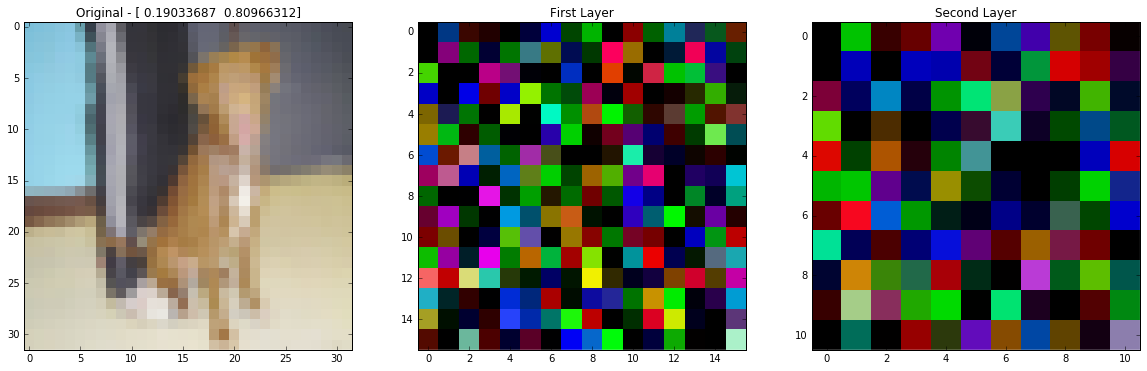

In [151]:
first_layer_rnd.set_weights(w1_old)
second_layer_rnd.set_weights(w2_old)
classifier_layer_rnd.set_weights(w3_old)

idx = 1
input_image = testData[idx]
first_output = input_layer_out.predict(input_image.reshape(1,testData[idx].shape[0]))
second_output = hidden_layer_out.predict(input_image.reshape(1,testData[idx].shape[0]))
second_output.resize(11*11*3)
final_output =  model.predict(input_image.reshape(1,input_image.shape[0]))

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow((input_image.reshape(32,32,3)), interpolation='none')
plt.title("Original - "+str(final_output[0]))
plt.subplot(132)
plt.imshow(first_output.reshape(16,16,3),interpolation='none')
plt.title("First Layer")
plt.subplot(133)
plt.imshow(second_output.reshape(11,11,3),interpolation='none')
plt.title("Second Layer")
plt.show()

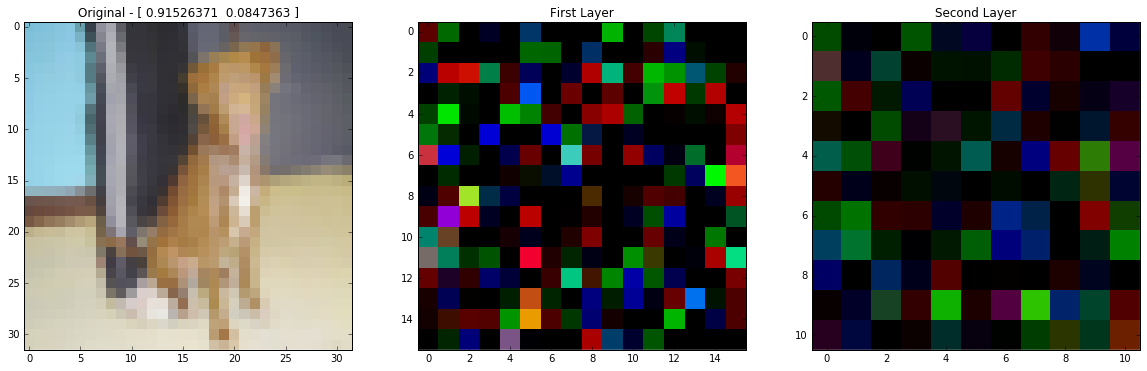

In [152]:
# set the weights using the ones from our trained model:
# (the results must be the same now...)
first_layer_rnd.set_weights(w1)
second_layer_rnd.set_weights(w2)
classifier_layer_rnd.set_weights(w3)

idx = 1
input_image = testData[idx]
first_output = input_layer_out.predict(input_image.reshape(1,testData[idx].shape[0]))
second_output = hidden_layer_out.predict(input_image.reshape(1,testData[idx].shape[0]))
second_output.resize(11*11*3)
final_output =  model.predict(input_image.reshape(1,input_image.shape[0]))

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow((input_image.reshape(32,32,3)), interpolation='none')
plt.title("Original - "+str(final_output[0]))
plt.subplot(132)
plt.imshow(first_output.reshape(16,16,3),interpolation='none')
plt.title("First Layer")
plt.subplot(133)
plt.imshow(second_output.reshape(11,11,3),interpolation='none')
plt.title("Second Layer")
plt.show()